In [1]:
import torch
from torch.utils.data import Dataset, SubsetRandomSampler

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

device = torch.device("cuda:0")

In [2]:
import os
import csv
from PIL import Image
from datasets import CernDataset

In [21]:
train_folder = 'C:/Users/Николай/Desktop/CernProject/data'
dataset = CernDataset(train_folder, end_moment=2)

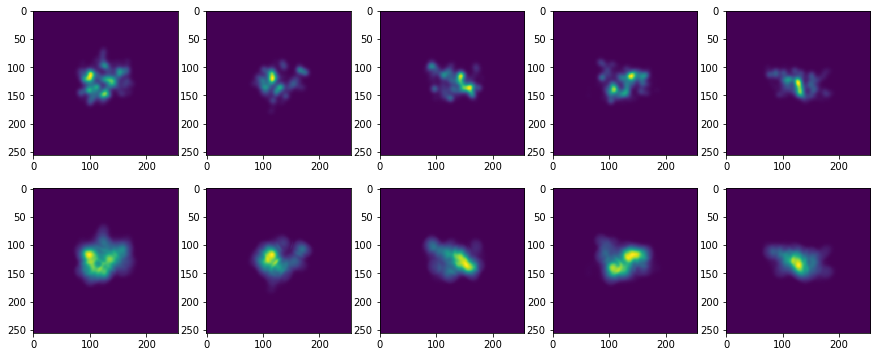

In [22]:
from visualisation import visualize_dataset

visualize_dataset(dataset, count=5, visualize_y=True)

In [23]:
batch_size = 4

data_size = len(dataset)
validation_fraction = .2

val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)

val_indices, train_indices = indices[:val_split], indices[val_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         sampler=val_sampler)

In [24]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, lr_scheduler=None):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train()
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value.item()

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_loss = compute_loss(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(float(val_loss))
        
        if lr_scheduler:
            lr_scheduler.step()
        
        print("Average loss: %f, Train accuracy: %f, Val loss: %f" % (ave_loss, train_accuracy, val_loss))
        
    return loss_history, train_history, val_history
        
def compute_loss(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Copy implementation from previous assignment
    # Don't forget to move the data to device before running it through the model!
    loss_accum = 0
    for i_step, (x, y) in enumerate(loader):
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        prediction = model(x_gpu)
        loss_value = loss(prediction, y_gpu)
        loss_accum += loss_value.item()

    ave_loss = loss_accum / i_step
    return ave_loss

In [ ]:
from model import Unet
import torch.optim as optim

def unet_loss(output, target):
    loss = 0.5 * torch.sum(torch.abs(output - target)) / torch.sum(torch.abs(target))
    return loss
        
model = Unet(hidden_size=32)

#model.type(torch.cuda.DoubleTensor)
model.to(device)

loss = unet_loss
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 0.079117, Train accuracy: 183073.401015, Val loss: 0.018011


In [ ]:
from visualisation import visualise_single_step_prediction
visualise_single_step_prediction(model, dataset)